# 基于Pandas的用电量统计分析 

通过对电表数据的能耗统计分析示例两种统计方法

1. **基于时间列分组**： DataFrame的index为样本序号，使用groupby(时间周期)

2. **基于时间索引分组**： DataFrame的index采样时间，使用重采样resample(时间周期)/ groupby(时间周期)

由于基于时间列分组方法是的DataFrame的index为样本序号， 基于时间索引DataFrame的索引(index)为采样时间，实际采样时间数据可能有误，这时基于时间列分组方法便于进行数据校正，所以，基于时间列分组方法更稳健
 

安装读取Excel文件的Python软件包xlrd
```
python -m pip install xlrd
```

配置Matplotlib显示中文

In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams  # figure Params
rcParams['font.sans-serif'] = ['FangSong']  # Chinese-FangSong

## 1 能耗分析DataFrame

* data: 用电量DataFrame
* data_interval: 相邻两行记录数值差DataFrame
* merged_data: 合并data和data_interval的DataFrame

### 1 用电量DataFrame


读用电量Execl文件生成DataFrame：data

![excel_powermeter](./img/excel-powermeter.jpg)


In [2]:
import pandas as pd
excelfile = './data/219_threePhaseIntelligentMeter.xls'
data =  pd.read_excel(excelfile,sheet_name='data',usecols=[1,2],parse_dates=["time"])
data

,time,value
0,2015-02-24 00:10:00,16340.75
1,2015-02-24 00:20:00,16340.77
2,2015-02-24 00:30:00,16340.80
3,2015-02-24 00:40:00,16340.83
4,2015-02-24 00:50:00,16340.86
...,...,...
1113,2015-03-03 17:40:00,16546.44
1114,2015-03-03 17:50:00,16546.56
1115,2015-03-03 18:00:00,16546.76
1116,2015-03-03 18:10:00,16546.95


**原始数据图**

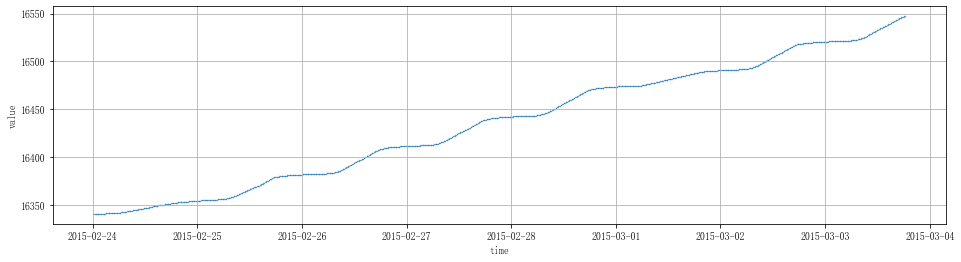

In [3]:
_=data.plot.scatter(figsize=(16,4),x="time",y="value",grid = True,s=0.1)

### 2 相邻两行记录数值差DataFrame



In [4]:
data_interval=data.diff()
data_interval.head(3)

,time,value
0,NaT,NaN
1,0 days 00:10:00,0.02
2,0 days 00:10:00,0.03


重命名 data_interval的列

* 采样周期数值： `data_interval[interval]`
* 采样周期内能耗：`data_interval[power_interval]`

In [5]:
data_interval=data_interval.rename(columns={"time": "interval", "value": "power_interval"})
data_interval.head(3)

,interval,power_interval
0,NaT,NaN
1,0 days 00:10:00,0.02
2,0 days 00:10:00,0.03


### 3 合并data和data_interval的DataFrame

In [6]:
merged_data = pd.merge(data,data_interval, left_index=True,right_index=True)
merged_data 

,time,value,interval,power_interval
0,2015-02-24 00:10:00,16340.75,NaT,NaN
1,2015-02-24 00:20:00,16340.77,0 days 00:10:00,0.02
2,2015-02-24 00:30:00,16340.80,0 days 00:10:00,0.03
3,2015-02-24 00:40:00,16340.83,0 days 00:10:00,0.03
4,2015-02-24 00:50:00,16340.86,0 days 00:10:00,0.03
...,...,...,...,...
1113,2015-03-03 17:40:00,16546.44,0 days 00:10:00,0.21
1114,2015-03-03 17:50:00,16546.56,0 days 00:10:00,0.12
1115,2015-03-03 18:00:00,16546.76,0 days 00:10:00,0.20
1116,2015-03-03 18:10:00,16546.95,0 days 00:10:00,0.19


**采样周期内能耗图**

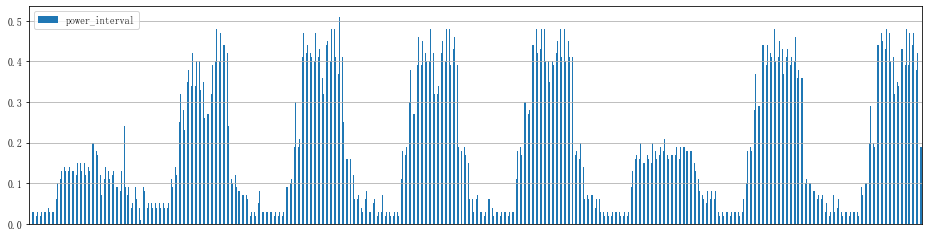

In [7]:
_=merged_data.plot.bar(figsize=(16,4),y="power_interval",grid = True,xticks=[])

## 2  数据采样统计

### 1 总样本数和采样天数

使用data

**总样本数**

In [8]:
data.count()

time     1118
value    1118
dtype: int64

**采样天数**

In [9]:
data["time"].max() - data["time"].min()

Timedelta('7 days 18:10:00')

### 2 最大、最小采样周期、能耗及时段

**最大、最小采样周期**

使用data_interval

In [10]:
max_interval=data_interval['interval'].max().total_seconds()/60
min_interval=data_interval['interval'].min().total_seconds()/60
print("最小采样周期(分钟)：", min_interval)    
print("最大采样周期(分钟)：", max_interval)  

最小采样周期(分钟)： 10.0
最大采样周期(分钟)： 10.0


**最大、最小采样周期内的能耗**

使用data_interval

In [11]:
max_power_interval=data_interval['power_interval'].max()
min_power_interval=data_interval['power_interval'].min()
print("采样周期内最大能耗：",max_power_interval)    
print("采样周期内最小能耗：",min_power_interval)  

采样周期内最大能耗： 0.5100000000020373
采样周期内最小能耗： 0.0


**最大、最小能耗采样时段**

使用`merged_data`

**查找采样能耗对应的采样时段函数**

In [12]:
def power_time_range(df,power_interval):
    sample_time=df[df["power_interval"]==power_interval] 
    sample_time_last=df.iloc[sample_time.index-1]
    power_time_range=pd.concat([sample_time_last,sample_time])
    return power_time_range

In [13]:
min_power_time_range=power_time_range(merged_data,min_power_interval)
min_power_time_range

,time,value,interval,power_interval
117,2015-02-24 19:40:00,16352.7,0 days 00:10:00,0.03
118,2015-02-24 19:50:00,16352.7,0 days 00:10:00,0.00


In [14]:
max_power_time_range=power_time_range(merged_data,max_power_interval)
max_power_time_range

,time,value,interval,power_interval
344,2015-02-26 09:30:00,16387.51,0 days 00:10:00,0.38
387,2015-02-26 16:40:00,16405.51,0 days 00:10:00,0.37
345,2015-02-26 09:40:00,16388.02,0 days 00:10:00,0.51
388,2015-02-26 16:50:00,16406.02,0 days 00:10:00,0.51


## 3 基于时间列分组的能耗统计

* 使用groupby（时间周期）

时间周期分组2种方式：

1. 取“time"列相应周期值，建立"month" "day" "hour"时间列,然后，用"month" "day" "hour"分组 -- 逻辑上更清晰
2. 使用时间列“time"取其相应周期值分组，不外建立列 - 少占用内存 

### 1 建立"month" "day" "hour"时间列

In [15]:
data["month"]=data["time"].dt.month
data["day"]=data["time"].dt.day
data["hour"]=data["time"].dt.hour
data

,time,value,month,day,hour
0,2015-02-24 00:10:00,16340.75,2,24,0
1,2015-02-24 00:20:00,16340.77,2,24,0
2,2015-02-24 00:30:00,16340.80,2,24,0
3,2015-02-24 00:40:00,16340.83,2,24,0
4,2015-02-24 00:50:00,16340.86,2,24,0
...,...,...,...,...,...
1113,2015-03-03 17:40:00,16546.44,3,3,17
1114,2015-03-03 17:50:00,16546.56,3,3,17
1115,2015-03-03 18:00:00,16546.76,3,3,18
1116,2015-03-03 18:10:00,16546.95,3,3,18


### 2 每日能耗


#### 1 每日能耗计算

In [16]:
# 取“time"列相应周期值，建立"month" "day" "hour"时间列,然后，用"month" "day" "hour"分组
max_day=data.groupby(["month","day"]).max()
min_day=data.groupby(["month","day"]).min()

# 取“time"列相应周期值分组 
# max_data.groupby([data["time"].dt.month,data["time"].dt.day]).max()
# min_day=data.groupby([data["time"].dt.month,data["time"].dt.day]).min()

day_power=max_day-min_day
day_power

time  value  hour
month day                             
2     24  0 days 23:40:00  13.62    23
      25  0 days 23:50:00  27.36    23
      26  0 days 23:50:00  29.62    23
      27  0 days 23:50:00  30.72    23
      28  0 days 23:50:00  31.37    23
3     1   0 days 23:50:00  17.04    23
      2   0 days 23:50:00  29.77    23
      3   0 days 18:20:00  26.51    18

#### 2 每日能耗图

* https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.bar.html

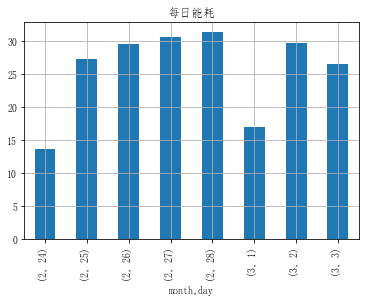

In [22]:
day_power.plot.bar(y="value",grid = True,legend=False)
_=plt.title("每日能耗")

### 3 每小时能耗

#### 1 时长差的能耗修正

由于采样周期的存在，采样时长小于统计时长，这个时长差在1个小时段内比较大.

如下图

* 2月24日0点，采样时长是40分钟，和1小时统计时长相差20分钟，33.3%
* 2月24日1点，采样时长是50分钟，和1小时统计时长相差10分钟，16.7%

![excel-powermeter_sample_hour_minute.jpg](./img/excel-powermeter_sample_hour_minute.jpg)

所以，需要对这个时间长差产生的能耗进行修正

一种修正方法：

$$修正后能耗=采用时长内能耗 \times \frac{统计时长(分钟)}{采样时长(分钟)}$$



#### 2 每小时能耗计算

In [19]:
max_hour=data.groupby(["month","day", "hour"]).max()
min_hour=data.groupby(["month","day", "hour"]).min()
hour_power=max_hour-min_hour
# 时长能耗修正
stat_minutes=60
sample_minutes=hour_power["time"].dt.seconds / stat_minutes
hour_power["value"]=hour_power["value"]*(stat_minutes/sample_minutes)
hour_power

time  value
month day hour                       
2     24  0    0 days 00:40:00  0.165
          1    0 days 00:50:00  0.156
          2    0 days 00:50:00  0.156
          3    0 days 00:50:00  0.204
          4    0 days 00:50:00  0.180
...                        ...    ...
3     3   14   0 days 00:50:00  2.616
          15   0 days 00:50:00  2.652
          16   0 days 00:50:00  2.544
          17   0 days 00:50:00  1.872
          18   0 days 00:20:00  1.140

[187 rows x 2 columns]

#### 3 每天小时能耗图

##### 1 每天小时能耗图

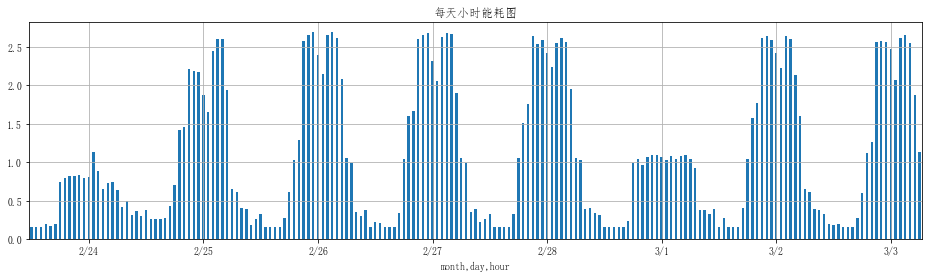

In [20]:
ax=hour_power.plot.bar(figsize=(16,4),y="value",grid = True,legend=False,xticks=[])

# set xtick
days=hour_power.index.get_level_values(1).nunique()
day_hours=hour_power.index.get_level_values(2).nunique()
xticks_location=[i*day_hours+day_hours//2 for i in range(days)]
xtick_labels=[]
for i in  range(days):
    index=hour_power.index[i*day_hours]
    xtick_labels.append(f'{index[0]}/{index[1]}')

ax.set_xticks(xticks_location)
ax.set_xticklabels(xtick_labels) 
_=plt.title("每天小时能耗图")

##### 2 某天小时能耗图

2月26日的小时能耗图

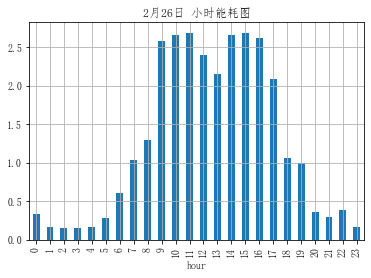

In [21]:
cur_month=2
cur_day=26
hour_power.loc[cur_month,cur_day,:].plot.bar(y="value",grid = True,legend=False)
_=plt.title(f"{cur_month}月{cur_day}日 小时能耗图")

##### 3 某两天小时能耗对比图

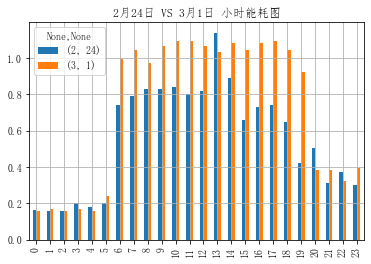

In [23]:
days=[(2,24),(3,1)] # (month,day)

days_power_dict={}
for day in days:
    days_power_dict[day]=hour_power.loc[day[0],day[1],:]["value"]

day_hours=len(days_power_dict[days[0]])
index=[h for h in range(day_hours)]
df = pd.DataFrame(days_power_dict, index=index)
df.plot.bar(grid = True)
_=plt.title(f"{days[0][0]}月{days[0][1]}日 VS {days[1][0]}月{days[1][1]}日 小时能耗图")

###  4 时间段能耗

时间段能耗计算时，统计时间段越大于1个小时，采样时间差带来的误差越小。

* 如果统计时间段较长，统计精度要求一般，可以不修正采样时间差带来的误差

* 如果统计时间段较短，统计精度要求较高，需要修正采样时间差带来的误差


#### 1 时间段能耗计算

如上午：8：00 - 12：59

In [24]:
hour_range={"start":8,"end":12}
data_hour_range=data[(data["hour"]>=hour_range["start"]) & (data["hour"]<=hour_range["end"])]
max_hour_range=data_hour_range.groupby(["month","day"]).max()
min_hour_range=data_hour_range.groupby(["month","day"]).min()
hour_range_power=max_hour_range-min_hour_range
hour_range_power

time  value  hour
month day                             
2     24  0 days 04:50:00   3.97     4
      25  0 days 04:50:00   9.68     4
      26  0 days 04:50:00  11.24     4
      27  0 days 04:50:00  11.54     4
      28  0 days 04:50:00  11.76     4
3     1   0 days 04:50:00   5.06     4
      2   0 days 04:50:00  11.75     4
      3   0 days 04:50:00  11.25     4

#### 2 时间段能耗图

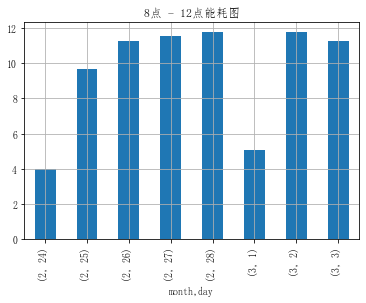

In [25]:
hour_range_power.plot.bar(y="value",grid = True,legend=False)
_=plt.title(f'{hour_range["start"]}点 - {hour_range["end"]}点能耗图')

#### 3 时长差能耗修正

#####  1 时段端点的时长差能耗修正函数

In [26]:
def add_power(data,node_hour_range,start_end):
    # 1 时段端点记录
    node=data[data["time"]==node_hour_range.iloc[0]["time"]]
    
    # 2 时段端点需补充的时长 minute_node
    if start_end=="start":
        minute_node=list(node["time"].dt.minute)[0]
    elif start_end=="end":
        minute_node=59-list(node["time"].dt.minute)[0]
        
    if minute_node!=0:
       # 3 时段端点的相邻采样记录
        if start_end=="start":
            index_neighbor= node.index+1
        elif start_end=="end":
            index_neighbor= node.index-1
        neighbor=data.iloc[index_neighbor]
        
        # 4 时段端点和相邻采样记录的时差minute_node_neighbor,能耗power_node_neighbor
        # default "start"
        minute_node_neighbor=list(neighbor["time"].dt.minute)[0]-list(node["time"].dt.minute)[0]
        power_node_neighbor=list(neighbor["value"])[0]-list(node["value"])[0]
        if start_end=="end":
            minute_node_neighbor=-minute_node_neighbor
            power_node_neighbor=-power_node_neighbor
        
        # 5 基于时段端点和相邻采样记录的时间差、时段端点需要补充的时长，计算需要补充时长的能耗 
        add_node_power=power_node_neighbor*(minute_node/minute_node_neighbor)
    else:    
        add_node_power=0
    return add_node_power                                        
 

##### 2 时长差能耗修正计算

In [27]:
add_power_start=add_power(data,min_hour_range,"start")
add_power_end=add_power(data,max_hour_range,"end")
hour_range_power["value"]=hour_range_power["value"]+add_power_start+add_power_end
hour_range_power

time   value  hour
month day                              
2     24  0 days 04:50:00   4.105     4
      25  0 days 04:50:00   9.815     4
      26  0 days 04:50:00  11.375     4
      27  0 days 04:50:00  11.675     4
      28  0 days 04:50:00  11.895     4
3     1   0 days 04:50:00   5.195     4
      2   0 days 04:50:00  11.885     4
      3   0 days 04:50:00  11.385     4

##### 3 修正后的时段能耗图

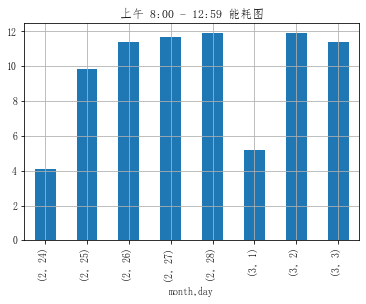

In [28]:
hour_range_power.plot.bar(y="value",grid = True,legend=False)
_=plt.title("上午 8:00 - 12:59 能耗图")

## 4 基于时间索引的能耗统计 

采样时间为index，使用**重采样**resample(时间周期)进行统计

* 这里,重采样周期resample(时间周期)类似于groupby(时间周期)

### 1 采样时间为index的DataFrame

In [29]:
import pandas as pd
excelfile = './data/219_threePhaseIntelligentMeter.xls'
data =  pd.read_excel(excelfile,sheet_name='data',usecols=[1,2],parse_dates=["time"])
# 采样时间为index
data_time=data.set_index("time",drop=False)
data_time

,time,value
time,,
2015-02-24 00:10:00,2015-02-24 00:10:00,16340.75
2015-02-24 00:20:00,2015-02-24 00:20:00,16340.77
2015-02-24 00:30:00,2015-02-24 00:30:00,16340.80
2015-02-24 00:40:00,2015-02-24 00:40:00,16340.83
2015-02-24 00:50:00,2015-02-24 00:50:00,16340.86
...,...,...
2015-03-03 17:40:00,2015-03-03 17:40:00,16546.44
2015-03-03 17:50:00,2015-03-03 17:50:00,16546.56
2015-03-03 18:00:00,2015-03-03 18:00:00,16546.76


### 2 每日能耗

重采样周期`resample(时间周期)`类似于`groupby(时间周期)`

如这里：
```python
max_day=data_time.resample("1d").max()
min_day=data_time.resample("1d").min()
```
等价于：

```python
max_day=data_time.groupby([data_time.index.month,data_time.index.day]).max() 
min_day=data_time.groupby([data_time.index.month,data_time.index.day]).max() 
```

In [30]:
max_day=data_time.resample("1d").max()
min_day=data_time.resample("1d").min()
power_day=max_day-min_day
power_day

,time,value
time,,
2015-02-24,0 days 23:40:00,13.62
2015-02-25,0 days 23:50:00,27.36
2015-02-26,0 days 23:50:00,29.62
2015-02-27,0 days 23:50:00,30.72
2015-02-28,0 days 23:50:00,31.37
2015-03-01,0 days 23:50:00,17.04
2015-03-02,0 days 23:50:00,29.77
2015-03-03,0 days 18:20:00,26.51


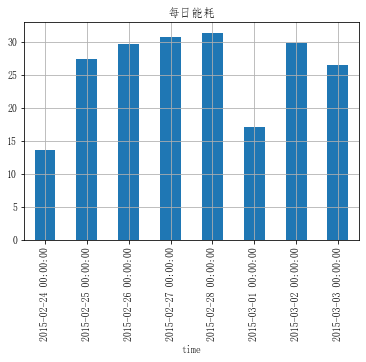

In [31]:
power_day.plot.bar(y="value",grid = True,legend=False)
_=plt.title("每日能耗")

### 3 每小时能耗

重采样`resample("1h")

In [32]:
max_hour=data_time.resample("1h").max()
min_hour=data_time.resample("1h").min()
power_hour=max_hour-min_hour
stat_minutes=60
sample_minutes=(max_hour["time"]-min_hour["time"]).dt.seconds / stat_minutes
power_hour["value"]=power_hour["value"]*(stat_minutes/sample_minutes)
power_hour

,time,value
time,,
2015-02-24 00:00:00,0 days 00:40:00,0.165
2015-02-24 01:00:00,0 days 00:50:00,0.156
2015-02-24 02:00:00,0 days 00:50:00,0.156
2015-02-24 03:00:00,0 days 00:50:00,0.204
2015-02-24 04:00:00,0 days 00:50:00,0.180
...,...,...
2015-03-03 14:00:00,0 days 00:50:00,2.616
2015-03-03 15:00:00,0 days 00:50:00,2.652
2015-03-03 16:00:00,0 days 00:50:00,2.544


#### 小时能耗图

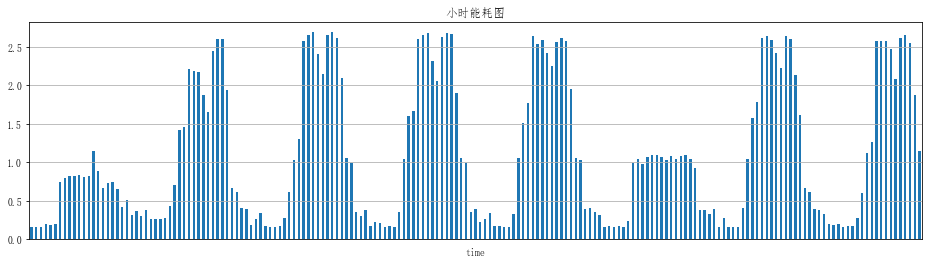

In [33]:
power_hour.plot.bar(figsize=(16,4),y="value",grid = True,legend=False,xticks=[])
_=plt.title("小时能耗图")

### 4 时间段能耗

时间段行的`resample("1D")`

In [34]:
hour_range={"start":8,"end":12}
hour_range_boolean=(data_time.index.hour>=hour_range["start"])&(data_time.index.hour<=hour_range["end"])
max_hours=data_time.loc[hour_range_boolean].resample("1D").max()
min_hours=data_time.loc[hour_range_boolean].resample("1D").min()
power_hours=max_hours-min_hours
power_hours

,time,value
time,,
2015-02-24,0 days 04:50:00,3.97
2015-02-25,0 days 04:50:00,9.68
2015-02-26,0 days 04:50:00,11.24
2015-02-27,0 days 04:50:00,11.54
2015-02-28,0 days 04:50:00,11.76
2015-03-01,0 days 04:50:00,5.06
2015-03-02,0 days 04:50:00,11.75
2015-03-03,0 days 04:50:00,11.25


#### 时间段能耗图

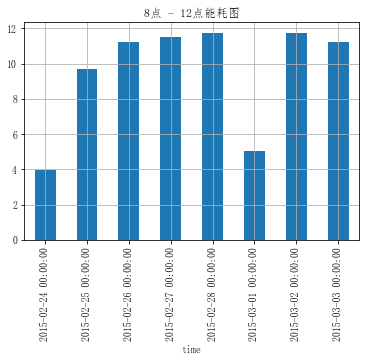

In [35]:
power_hours.plot.bar(y="value",grid = True,legend=False)
_=plt.title(f'{hour_range["start"]}点 - {hour_range["end"]}点能耗图')